<a href="https://colab.research.google.com/github/zyan369/RL19-Opinion-Leaders/blob/master/Followers_network_%26_centrality_metrics_2019_partial_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#a=[]
#while(1):
    #a.append(1)

In [0]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt
import networkx as nx  
import pandas as pd
import numpy as np
from scipy import sparse
import gc
import os

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
os.chdir("drive")
os.chdir("My Drive")
os.chdir("Colab Notebooks")

## Utility functions
Utility functions created to process data from long dictionaries.

>### degree_freq(G)

<br>**PARAMETERS:** G (graph) – A NetworkX graph.
<br>
<br>**RETURNS:**
<br>in_deg_freq --> Dictionary of Indegree values (as keys) and the number of nodes that have that indegree  (as a value).
<br>out_deg_freq --> Dictionary of Outdegree values (as keys) and the number of nodes that have that outdegree (as a value).
<br>all_in_deg --> Dictionary of all nodes, with their indegree as value (native function of NetworkX does not return a dictionary)
<br> all_out_deg --> Dictionary of all nodes, with their outdegree as value (native function of NetworkX does not return a dictionary)
<br>
<br>**RETURN TYPE:** dictionary


In [0]:
def degree_freq(graph):
    in_deg_freq = {}
    all_in_deg ={}

    out_deg_freq = {}
    all_out_deg ={}
    
    for n in graph.nodes():
        in_deg = graph.in_degree(n)
        out_deg= graph.out_degree(n)
        
        all_in_deg[n] = in_deg
        all_out_deg[n]= out_deg
        
        if in_deg not in in_deg_freq:
            in_deg_freq[in_deg] = 0
        in_deg_freq[in_deg]+= 1
        
        if out_deg not in out_deg_freq:
            out_deg_freq[out_deg] = 0
        out_deg_freq[out_deg]+= 1      
    
    return in_deg_freq, all_in_deg, out_deg_freq, all_out_deg

>### get_top_values(d, t)

Given a dictionary, this function orders it by the value (descending order) and returns a smaller dictionary with the N-top values with their keys.
**PARAMETERS:** 
<br> d (dictionary) – a dictionary with un-ordered values
<br> t (int) – the number of top values to retrieve
<br>**RETURNS:**
<br> new_d --> Dictionary with ordered keys, with highest values.
<br>**RETURN TYPE:** dictionary


In [0]:
def get_top_values(d, t):
    new_d={}
    sorted_keys = sorted(d, key=d.get, reverse=True)
    for x in sorted_keys[:t]:
        new_d[x] = d[x]
    return new_d

>### get_top_keys(D,top)

Given a dictionary, this function orders it by the key (descending order) and returns a list of tuples, with the N-top keys and their values.
**PARAMETERS:** 
<br> D (dictionary) – a dictionary with un-ordered keys
<br> top (int) – the number of n top values 
<br>**RETURNS:**
<br> item --> List of tuples (key,value)
<br>**RETURN TYPE:** list


In [0]:
def get_top_keys(dictionary, top):
    item = list(reversed(sorted(dictionary.items())))
    return item[:top]

## Load dataset of users & followers
For this purpose, we are using the files *followers.csv* and *users.csv*, contained in the MySQL dump that is published by **The GHTorrent project**.
<br>The file *followers.csv* contains three columns, containing the date of creation of the link and the user IDs, indicating if a user follows another. In graphs and network theory, this type of table it is know as "adjacency list". 
<br>
<br>The file *users.csv* contains several columns with user information(user name, id, creation of the account, country, company, email, etc). We use this table only to map the relationship between *user ID number* and *login name*.
<br>
<br>The used tables contain all users ( and their relationships) that were created **until January 2019**.
<br>
<br>__[Link to download the MySQL dump: mysql-2019-01-01.tar.gz (size of 90.1 GB)](http://ghtorrent-downloads.ewi.tudelft.nl/mysql/mysql-2019-01-01.tar.gz)__

In [0]:
#LOAD DATA FROM CSV, only load the first two columns
df_f = pd.read_csv('./new_upload_Aditya/followers.csv', index_col=False, usecols=[0,1], names=['follower_id', 'user_id'])

In [11]:
df_f.shape[0]
df_f.head()

29809738

,follower_id,user_id
0,1,2
1,1,4
2,1,17896
3,1,21523
4,1,29121


### Preliminar size of full network
Before creating the Network, we can get some preliminar statistic about it:
<br>Number of edges (connections) = **29,809,738**


In [12]:
print("Number of edges:", df_f.shape[0])

Number of edges: 29809738


### Create full network of users

In [0]:
#create empty directed Graph
full_followers_graph = nx.DiGraph()

In [0]:
# the directed graph maps the direction as: [follower --> user]
# for this purpose, the graph is created using the dataframe as a list
full_followers_graph.add_edges_from(df_f.values.tolist())


In [15]:
# print and check some stats about the full network
print(nx.info(full_followers_graph))

Name: 
Type: DiGraph
Number of nodes: 5375944
Number of edges: 29809738
Average in degree:   5.5450
Average out degree:   5.5450


In [0]:
# calculates some statistics
in_deg_freq, all_in_deg, out_deg_freq, all_out_deg = degree_freq(full_followers_graph)

In [0]:
#since we are not doing further calculations with this full network, we release the memory 
del full_followers_graph

In [19]:
#use the Garbage collect utility
gc.collect()
gc.collect()

0

0

### Identify nodes to remove

Since we lack the computational power to compute Page Rank for such a big network (**5,375,944 nodes** with **29,809,738 connections** between them), the following modeling choice was taken: 
>Trim from the network nodes with 5 followers or less AND that are following 5 or less users (average in/out degree is 5.5450).

>There are inactive users and users who belong to organizations (type=0 or ORG). Because we focus on people, only accounts associated with people will be included.

<br>
<br>Therefore, is necesary to identify users that fill the conditions:

> indegree>=5 AND outdegree>=5)

> type = 0 or type = ORG





In [0]:
# transform statistics into pandas dataframe
df_all_in_degree = pd.Series(all_in_deg).to_frame('number_followers')
df_all_in_degree['user_id'] = df_all_in_degree.index
df_all_in_degree.reset_index(inplace=True,drop=True)
#swap cols
#df_all_in_degree = df_all_in_degree.reindex(columns=['user_id', 'number_followers'])

In [21]:
df_all_in_degree.shape[0]

5375944

In [0]:
# transform into pandas dataframe
df_all_out_degree = pd.Series(all_out_deg).to_frame('following')
df_all_out_degree['user_id'] = df_all_out_degree.index
df_all_out_degree.reset_index(inplace=True,drop=True)
#swap cols
#df_all_out_degree = df_all_out_degree.reindex(columns=['user_id', 'following'])


In [23]:
df_all_out_degree.shape[0]

5375944

In [0]:
#release memory
del all_in_deg
del all_out_deg

In [26]:
#use the Garbage collect utility
gc.collect()
gc.collect()

0

0

In [27]:
# Identify Users with 5 followers or less = 4,608,226
#(df_all_in_degree.loc[ df_all_in_degree['number_followers'] <=5 ]).shape[0]
df_remove_indegree = (df_all_in_degree.loc[ df_all_in_degree['number_followers'] <=5 ])
df_remove_indegree.shape[0]
#df_remove_indegree.head()

4608226

In [28]:
# Identify Users following 5 or less people= 4,523,454
#(df_all_out_degree.loc[ df_all_out_degree['following'] <=5 ]).shape[0]
df_remove_outdegree = (df_all_out_degree.loc[ df_all_out_degree['following'] <=5 ])
df_remove_outdegree.shape[0]
#df_remove_outdegree.head()

4523454

In [0]:
# we don't need that column
del df_remove_indegree['number_followers']

In [0]:
# we don't need that column
del df_remove_outdegree['following']

In [31]:
# we do a left join, meaning that we aim to delete nodes that
# are following 5 users or less, ONLY if they are being follow by 5 users or less
# Users considered to remove: 4,608,226
df_remove= df_remove_indegree.merge(df_remove_outdegree, how='left')
df_remove.shape[0]
#df_remove.head()

4608226

In [0]:
#release memory
del df_remove_outdegree
del df_remove_indegree
del df_all_out_degree
del df_all_in_degree

In [33]:
#use the Garbage collect utility
gc.collect()
gc.collect()

0

0

In [34]:
import sys
# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('df_f', 476955960),
 ('df_remove', 73731640),
 ('in_deg_freq', 73824),
 ('out_deg_freq', 73824),
 ('InteractiveShell', 1056),
 ('degree_freq', 136),
 ('get_top_keys', 136),
 ('get_top_values', 136),
 ('drive', 80),
 ('np', 80),
 ('nx', 80),
 ('pd', 80),
 ('plt', 80),
 ('sparse', 80)]

In [35]:
# we load this file to identify users with type = 0 or type =ORG
#LOAD DATA FROM CSV
df_u = pd.read_csv('./new_upload_Aditya/users.csv', sep=',', index_col=False, error_bad_lines=False)

#We need to cut the columns we are not going to use and change the header of the dataframe
df_u.columns = ['id', 'login','company','created_at','type','fake','deleted','long','lat','country_code','state','city','location']
cols_to_keep = ['id', 'login','type']
df_u = df_u[cols_to_keep]
df_u.head()

b'Skipping line 28844: expected 13 fields, saw 14\n'
b'Skipping line 127060: expected 13 fields, saw 16\nSkipping line 130093: expected 13 fields, saw 14\n'
b'Skipping line 140110: expected 13 fields, saw 14\n'
b'Skipping line 223215: expected 13 fields, saw 16\nSkipping line 240360: expected 13 fields, saw 15\n'
b'Skipping line 274140: expected 13 fields, saw 14\nSkipping line 287603: expected 13 fields, saw 14\nSkipping line 303874: expected 13 fields, saw 14\nSkipping line 327509: expected 13 fields, saw 15\n'
b'Skipping line 455083: expected 13 fields, saw 14\n'
b'Skipping line 491713: expected 13 fields, saw 14\n'
b'Skipping line 828312: expected 13 fields, saw 14\n'
b'Skipping line 870291: expected 13 fields, saw 15\n'
b'Skipping line 935277: expected 13 fields, saw 14\n'
b'Skipping line 1117721: expected 13 fields, saw 24\nSkipping line 1132208: expected 13 fields, saw 14\n'
b'Skipping line 1257324: expected 13 fields, saw 15\n'
b'Skipping line 1353050: expected 13 fields, saw 1

,id,login,type
0,1,tosch,USR
1,2,jmettraux,USR
2,3,SMGNMSKD,USR
3,4,kennethkalmer,USR
4,5,weppos,USR


In [0]:
#we are not considering the ORG (organization accounts) and the ones labeled with 0 (innactive accounts)
df_ORG = df_u.loc[ df_u['type']=='ORG']
df_zero= df_u.loc[ df_u['type']=='0']

# we don't need this columns
del df_ORG['login']
del df_ORG['type']
del df_zero['login']
del df_zero['type']


### Create new dataset, trimmed

In [0]:
# 1 - delete nodes from the 'user_id' col
df_trim = df_f[~df_f.user_id.isin(df_remove.user_id)]

In [0]:
# 2 - delete nodes from the 'follower_id' col
df_trim = df_trim[~df_trim.follower_id.isin(df_remove.user_id)]

In [0]:
# 3 - delete nodes that are ORG type
df_trim = df_trim[~df_trim.user_id.isin(df_ORG.id)]
df_trim = df_trim[~df_trim.follower_id.isin(df_ORG.id)]

In [0]:
# delete nodes that are ORG type
df_trim = df_trim[~df_trim.user_id.isin(df_zero.id)]
df_trim = df_trim[~df_trim.follower_id.isin(df_zero.id)]


In [41]:
#757,571 nodes
len(df_trim['user_id'].unique())

757571

In [42]:
#16,546,310 edges
df_trim.shape[0]

16546310

In [43]:
df_trim.head()

,follower_id,user_id
0,1,2
1,1,4
2,1,17896
3,1,21523
4,1,29121


In [44]:
# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('df_u', 3968749608),
 ('df_f', 476955960),
 ('df_trim', 397111464),
 ('df_remove', 73731640),
 ('df_ORG', 18589624),
 ('in_deg_freq', 73824),
 ('out_deg_freq', 73824),
 ('InteractiveShell', 1056),
 ('degree_freq', 136),
 ('df_zero', 136),
 ('get_top_keys', 136),
 ('get_top_values', 136),
 ('cols_to_keep', 88),
 ('drive', 80),
 ('np', 80),
 ('nx', 80),
 ('pd', 80),
 ('plt', 80),
 ('sparse', 80)]

In [0]:
# delete variables that are not needed, to release memory
#del df_f
#del df_remove
del df_ORG
del df_zero

In [47]:
#use the Garbage collect utility
gc.collect()
gc.collect()

0

0

### User login substitution

In [0]:
# Make a copy of the all users dataframe
# but, only keep the users and logins that are gonna be loaded in the network
df_user_trimm = df_u[ df_u.id.isin(df_trim.user_id) ]

In [49]:
# users: 757,545
df_user_trimm.shape[0]
del df_user_trimm['type']
df_user_trimm.head(2)

757545

,id,login
0,1,tosch
1,2,jmettraux


In [0]:
# Create a dictionary of all user_id and login name

#my_name_dict = dict(df_user_trimm.to_dict('split')['data'])
#len(my_name_dict)

In [0]:
# Create a new dataframe, where we will do the id --> login substitutio

#df_trim_follower = df_trim.replace({"follower_id": my_name_dict})

In [0]:
#df_trim_follower.head()

In [0]:
#substitute the other column

#df_trim_follower = df_trim_follower.replace({"user_id": my_name_dict})
#df_trim_follower.head()

In [57]:

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('df_trim', 397111464),
 ('df_user_trimm', 62103104),
 ('in_deg_freq', 73824),
 ('out_deg_freq', 73824),
 ('InteractiveShell', 1056),
 ('degree_freq', 136),
 ('get_top_keys', 136),
 ('get_top_values', 136),
 ('cols_to_keep', 88),
 ('drive', 80),
 ('np', 80),
 ('nx', 80),
 ('pd', 80),
 ('plt', 80),
 ('sparse', 80)]

In [0]:
#del my_name_dict
del df_u
#del df_user_trimm
del df_remove
#del df_trim
del df_f

In [59]:
gc.collect()
gc.collect()

0

0

### Create **partial** directed graph

In [0]:
#create empty directed Graph
followers_graph = nx.DiGraph()

In [0]:
#add edges to the Graph
followers_graph.add_edges_from(df_trim.values.tolist())

New trimmed network:
<br> 760,467 nodes
<br> 16,546,310 edges

In [62]:
print(nx.info(followers_graph))

Name: 
Type: DiGraph
Number of nodes: 760467
Number of edges: 16546310
Average in degree:  21.7581
Average out degree:  21.7581


### Calculate page rank

In [0]:
page_rank = nx.pagerank(followers_graph, max_iter=60)

In [0]:
# calculate top users with highest page rank values
top_page_rank = get_top_values(page_rank, 1000)

In [0]:
#use the user_id as index
user_names = df_user_trimm.set_index('id')['login']

df_top_page_rank = pd.DataFrame.from_dict(data=top_page_rank, orient='index',columns=['Page_rank'])
df_top_page_rank['login'] = np.array(list(map(user_names.get,top_page_rank.keys())))

In [88]:
df_top_page_rank = df_top_page_rank.reset_index()
df_top_page_rank.head(15)

,index,Page_rank,login
0,5203,0.008165,torvalds
1,896,0.002421,JakeWharton
2,376498,0.002159,Tj
3,9236,0.001743,mojombo
4,417948,0.001526,gaearon
5,1779,0.001435,paulirish
6,6240,0.001394,addyosmani
7,616741,0.001387,ruanyf
8,18556,0.001174,yyx990803
9,3871,0.001165,sindresorhus


In [0]:
#save results as CSV
df_top_page_rank.to_csv('./results/1000_page_rank.csv')

### Calculate HITS

In [0]:
#calculates Hubs and Authorities, returns two dictionaries
hubs, auth = nx.hits(followers_graph, max_iter=60)

In [0]:
top_auths = get_top_values(auth, 1000)

In [109]:
df_top_auths = pd.DataFrame.from_dict(data=top_auths, orient='index',columns=['auth'])
df_top_auths['login'] = np.array(list(map(user_names.get,top_auths.keys())))
df_top_auths = df_top_auths.reset_index()
df_top_auths.head(15)

,index,auth,login
0,5203,0.000044,torvalds
1,376498,0.000043,Tj
2,6240,0.000037,addyosmani
3,3871,0.000037,sindresorhus
4,1779,0.000035,paulirish
5,18556,0.000031,yyx990803
6,417948,0.000029,gaearon
7,1570,0.000028,defunkt
8,1199,0.000028,substack
9,796,0.000027,kennethreitz


In [0]:
#save results as CSV
df_top_auths.to_csv('./results/1000_auths_rank.csv')

Top hubs

In [110]:
top_hubs = get_top_values(hubs, 1000)

df_top_hubs = pd.DataFrame.from_dict(data=top_hubs, orient='index',columns=['hub'])
df_top_hubs['login'] = np.array(list(map(user_names.get,top_hubs.keys())))
df_top_hubs = df_top_hubs.reset_index()
df_top_hubs.head()


,index,hub,login
0,13330706,0.009984,angusshire
1,5956845,0.008138,4148
2,6295826,0.005918,ternsip
3,1640412,0.005483,cusspvz
4,33579752,0.005378,dalinhuang99


In [0]:
#save results as CSV
df_top_hubs.to_csv('./results/1000_hubs_rank.csv')

## Degree centrality

In [0]:
#calculates degree centrality, returns a dictionary
deg_centr = nx.degree_centrality(followers_graph)

In [0]:
top_deg_centr = get_top_values(deg_centr, 1000)

In [96]:
df_top_deg_centr = pd.DataFrame.from_dict(data=top_deg_centr, orient='index',columns=['cent_deg'])
df_top_deg_centr['login'] = np.array(list(map(user_names.get,top_deg_centr.keys())))
df_top_deg_centr = df_top_deg_centr.reset_index()
df_top_deg_centr.head(15)

,index,cent_deg,login
0,13330706,0.238706,angusshire
1,5956845,0.177598,4148
2,1302201,0.152805,KevinHock
3,1640412,0.147009,cusspvz
4,33579752,0.146121,dalinhuang99
5,6295826,0.127144,ternsip
6,5045042,0.111083,akmoose
7,3688872,0.105241,MichalPaszkiewicz
8,3148103,0.090124,alex-cory
9,10428329,0.087062,popsiclesarecool


In [0]:
#save results as CSV
df_top_deg_centr.to_csv('./results/1000_deg_centrality.csv')

## In-degree centrality

In [0]:
#calculates degree centrality, returns a dictionary
in_deg_centr = nx.in_degree_centrality(followers_graph)

In [0]:
top_in_deg_centr = get_top_values(in_deg_centr, 1000)

In [102]:
df_top_in_deg_centr = pd.DataFrame.from_dict(data=top_in_deg_centr, orient='index',columns=['in_degree_cent'])
df_top_in_deg_centr['login'] = np.array(list(map(user_names.get, top_in_deg_centr.keys())))
df_top_in_deg_centr = df_top_in_deg_centr.reset_index()
df_top_in_deg_centr.head(15)

,index,in_degree_cent,login
0,5203,0.077141,torvalds
1,376498,0.041151,Tj
2,6240,0.033024,addyosmani
3,896,0.031734,JakeWharton
4,1779,0.030888,paulirish
5,417948,0.029583,gaearon
6,3871,0.029361,sindresorhus
7,616741,0.027001,ruanyf
8,18556,0.026356,yyx990803
9,796,0.021223,kennethreitz


In [0]:
#save results as CSV
df_top_in_deg_centr.to_csv('./results/1000_in_deg_centrality.csv')

## EigenCentrality

In [0]:
eigendeg_centr = nx.eigenvector_centrality(followers_graph)

In [0]:
top_eigendeg_centr = get_top_values(eigendeg_centr, 1000)

In [0]:
df_top_eigendeg_centr = pd.DataFrame.from_dict(data=top_eigendeg_centr, orient='index',columns=['eigen_cent'])
df_top_eigendeg_centr['login'] = np.array(list(map(user_names.get,top_auths.keys())))
df_top_eigendeg_centr.head()

In [0]:
#save results as CSV
df_top_eigendeg_centr.to_csv('./results/1000_eigen_centrality.csv'))

## Plot frequency distribution

In [0]:
#parses list of indegree values and outdegree values
idf = (sorted(in_deg_freq.items()))
odf = (sorted(out_deg_freq.items()))

<Figure size 1080x720 with 0 Axes>

Text(0.5, 0, 'Degree')

Text(0, 0.5, 'Number of users')

Text(0.5, 1.0, 'Followers network in Github - Jan 2019')

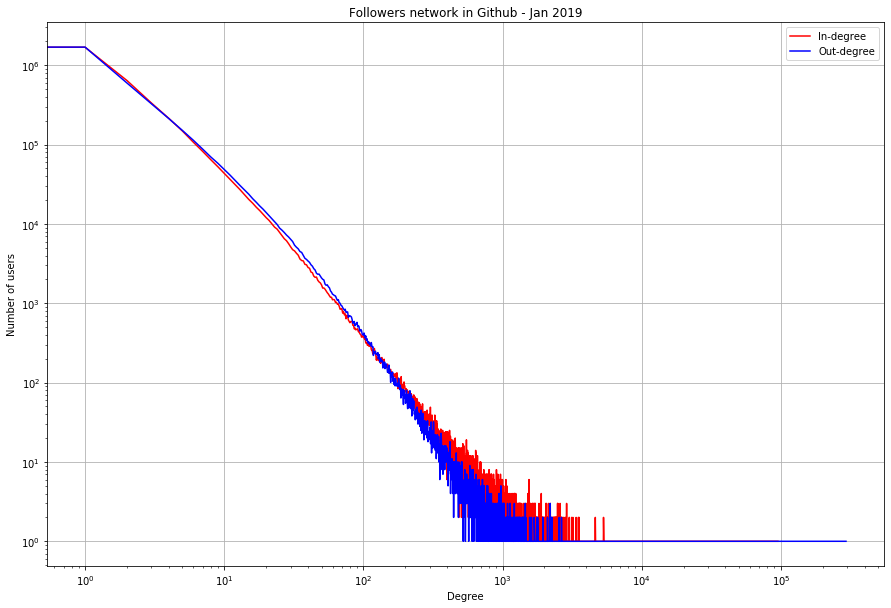

In [114]:
plt.figure(figsize =(15, 10))
plt.grid(True)
plt.loglog([k for (k,v) in idf], [v for (k,v ) in idf], 'r-') # in-degree
plt.loglog([k for (k,v) in odf],[v for (k,v ) in odf], 'b-')  # out-degree
plt.legend(['In-degree', 'Out-degree'])
plt.xlabel('Degree')
plt.ylabel('Number of users')
plt.title('Followers network in Github - Jan 2019')


In [115]:
# save generated image
plt.savefig('./results/degree_distribution_2019.png')

<Figure size 432x288 with 0 Axes>